In [ ]:
import sys, os

root_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
if root_path not in sys.path:
    sys.path.append(root_path)

In [ ]:
from data.load_tinyimagenet import *

train_loader, val_loader, test_loader = get_tinyimagenet200_hf_dataloaders(
    batch_size=64, data_dir="./data",
    num_workers=2,
    val_split=0.1, seed=77)


---


In [ ]:
import torch.nn as nn
from src.training.train_full_model import * 
from src.training.metrics import * 
from src.training.eval_one_epoch_logs import *
from src.Model_A_OutGridNet import * 


def outgrid_64x64(drop_path=0.07):
    return [
        StageCfg(dim=48,  depth=1, num_heads=2, grid_size=8, outlook_heads=2, drop_path=drop_path),
        StageCfg(dim=96,  depth=2, num_heads=3, grid_size=8, outlook_heads=3, drop_path=drop_path),
        StageCfg(dim=192, depth=2, num_heads=6, grid_size=4, outlook_heads=6, drop_path=drop_path),
        StageCfg(dim=256, depth=1, num_heads=8, grid_size=2, outlook_heads=8, drop_path=drop_path),
    ]

stages = outgrid_64x64()


model = MaxOutNet(
    num_classes=200,
    stages=stages,
    stem_dim=64,
    dpr_max=0.1)

device = "cuda" if torch.cuda.is_available() else "cpu"

In [26]:
def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

n_params = count_trainable_parameters(model)
print(f"Trainable parameters: {n_params:,}")

Trainable parameters: 6,264,452


In [28]:
avg_loss, metrics = evaluate_one_epoch_logs(
    model=model,
    dataloader=test_loader,
    device="cuda",
    use_amp=True,
    autocast_dtype="fp16",
    channels_last=False,
    measure_flops=True,
    flops_warmup_batches=1)

print(f"loss: {avg_loss:.4f}")
print(f"top1: {metrics['top1']:.2f} | top3: {metrics['top3']:.2f} | top5: {metrics['top5']:.2f}")

print(f"throughput: {metrics['imgs_per_sec']:.1f} imgs/s | epoch: {metrics['epoch_time_sec']:.2f}s | ms/batch: {metrics['ms_per_batch']:.2f}")
print(f"GPU mem: alloc={metrics['gpu_mem_allocated_mib']:.0f} MiB | reserved={metrics['gpu_mem_reserved_mib']:.0f} MiB | peak={metrics['gpu_mem_peak_allocated_mib']:.0f} MiB")
print(f"model: params={int(metrics['model_params']):,} | param_size={metrics['model_param_size_mib']:.1f} MiB")

flops = metrics["flops_per_forward"]
macs  = metrics["macs_per_forward"]

print(
    f"Compute (per forward): "
    f"{format_ops(flops, 'FLOPs')} | "
    f"{format_ops(macs, 'MACs')}")

stages.1.0.dp2, stages.1.0.dp3, stages.1.0.outlook.dp1, stages.1.0.outlook.dp2, stages.1.1.dp2, stages.1.1.dp3, stages.1.1.outlook.dp1, stages.1.1.outlook.dp2, stages.2.0.dp2, stages.2.0.dp3, stages.2.0.outlook.dp1, stages.2.0.outlook.dp2, stages.2.1.dp2, stages.2.1.dp3, stages.2.1.outlook.dp1, stages.2.1.outlook.dp2, stages.3.0.dp2, stages.3.0.dp3, stages.3.0.outlook.dp1, stages.3.0.outlook.dp2


loss: 5.3501
top1: 0.44 | top3: 1.28 | top5: 2.21
throughput: 306.4 imgs/s | epoch: 32.63s | ms/batch: 176.01
GPU mem: alloc=34 MiB | reserved=1148 MiB | peak=846 MiB
model: params=6,264,452 | param_size=23.9 MiB
Compute (per forward): 1.56 GFLOPs | 780.54 MMACs


In [ ]:
import random, numpy as np

seed = 77
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

random.seed(seed);
np.random.seed(seed)
torch.backends.cudnn.benchmark = True


history1, model_maxvit_nano = train_model(
    model=model,
    train_loader=train_loader,
    epochs=25,
    val_loader=val_loader,
    device=device,

    lr=5e-4,
    weight_decay=0.05,

    autocast_dtype="fp16" if device == "cuda" else "fp32",
    use_amp=(device == "cuda"),
    grad_clip_norm=1.0,

    warmup_ratio=0.05,
    min_lr=1e-6,

    label_smoothing=0.1,

    print_every=400,
    save_path="best_model.pt",
    last_path="last_model.pt",
    resume_path=None,

    # Augmentations
    mix_prob=0.5,
    mixup_alpha=0.4,
    cutmix_alpha=0.4,

    num_classes=200, early_stop_patience=25,
    channels_last=True)

#A100

=== Run config ===
device=cuda | amp=True | autocast_dtype=fp16 | channels_last=True
epochs=25 | steps/epoch=1406 | total_steps=35150 | warmup_steps=1757
batch_size=64 | input_shape=(64, 3, 64, 64) | num_classes=200
opt=AdamW | lr=0.0005 | wd=0.05 | grad_clip_norm=1.0
aug: mix_prob=0.5 | mixup_alpha=0.4 | cutmix_alpha=0.4 | label_smoothing=0.1

=== Epoch 1/25 ===
[train step 400/1406] loss 5.0747 | top1 2.98% | top3 7.34% | top5 10.65% | 670.0 img/s | lr 1.14e-04 | gnorm 3.512 | clip 100.0% | oflow 0 | nonfinite 0 | scale 65536.0
[train step 800/1406] loss 4.8654 | top1 4.83% | top3 11.22% | top5 15.83% | 670.7 img/s | lr 2.28e-04 | gnorm 3.597 | clip 100.0% | oflow 0 | nonfinite 0 | scale 65536.0
[train step 1200/1406] loss 4.7026 | top1 6.50% | top3 14.41% | top5 19.99% | 671.7 img/s | lr 3.41e-04 | gnorm 3.558 | clip 100.0% | oflow 0 | nonfinite 0 | scale 65536.0
[train step 1406/1406] loss 4.6231 | top1 7.43% | top3 16.11% | top5 22.05% | 671.8 img/s | lr 4.00e-04 | gnorm 3.534 | c

In [ ]:
evaluate_one_epoch(model=model,dataloader=test_loader)

(1.8515890508651733, {'top1': 56.77, 'top3': 74.09, 'top5': 79.72})

In [ ]:
import pickle

with open("OutGrid_TinyImagnet200.pkl", "wb") as f:
    pickle.dump(history1, f)

In [ ]:
from src.data.load_cifrar100_C import *

quick_corruptions = ["gaussian_noise", "motion_blur", "jpeg_compression", "fog", "pixelate"]

results_quick = evaluate_tinyc_suite(
    model=model,
    evaluate_one_epoch_fn=evaluate_one_epoch,
    reference_clean_loader=test_loader,
    data_dir="./data",
    batch_size=128,
    img_size=64,
    num_workers=2,
    corruptions=quick_corruptions,
    severities=(1, 3, 5),
    verbose=True)

print(summarize_tinyc_results(results_quick, metric_key="top1"))
print(summarize_tinyc_results(results_quick, metric_key="top5"))

[Tiny-ImageNet-C] Downloading tar to: data/Tiny-ImageNet-C.tar
[Tiny-ImageNet-C] Extracting: data/Tiny-ImageNet-C.tar


/tmp/ipython-input-3739125734.py:126: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tf.extractall(data_dir)


    gaussian_noise | s=1 | n=9100 | loss=3.0035 | top1=37.71 | top5=62.01
    gaussian_noise | s=3 | n=9100 | loss=5.3872 | top1=12.32 | top5=28.45
    gaussian_noise | s=5 | n=9100 | loss=6.2998 | top1=5.85 | top5=15.42
       motion_blur | s=1 | n=9100 | loss=3.4641 | top1=30.25 | top5=53.67
       motion_blur | s=3 | n=9100 | loss=4.3718 | top1=18.90 | top5=39.91
       motion_blur | s=5 | n=9100 | loss=5.0769 | top1=12.04 | top5=29.65
  jpeg_compression | s=1 | n=9100 | loss=3.0186 | top1=36.64 | top5=61.35
  jpeg_compression | s=3 | n=9100 | loss=3.1698 | top1=34.31 | top5=58.35
  jpeg_compression | s=5 | n=9100 | loss=3.7408 | top1=26.00 | top5=48.84
               fog | s=1 | n=9100 | loss=2.8811 | top1=38.58 | top5=63.35
               fog | s=3 | n=9100 | loss=3.5111 | top1=28.91 | top5=53.58
               fog | s=5 | n=9100 | loss=5.1007 | top1=11.45 | top5=28.81
          pixelate | s=1 | n=9100 | loss=2.6787 | top1=41.92 | top5=67.31
          pixelate | s=3 | n=9100 | los

In [ ]:
from src.data.load_cifrar100_C import *

test_loader_clean_182 = get_clean_test_loader_intersection_182(
    test_loader_clean=test_loader,
    reference_train_loader=train_loader,
    data_dir="./data",
    corruption_name="motion_blur",
    corruption_level=3,
    batch_size=128,
    num_workers=2)

clean_loss, clean_metrics = evaluate_one_epoch(model=model, dataloader=test_loader_clean_182)
print("clean_182:", clean_loss, clean_metrics)

[clean∩C] keep_classes=182 | drop_classes=18
[clean∩C] keep_samples=9100 / total=10000
clean_182: 1.8020548181219416 {'top1': 57.81318681318681, 'top3': 74.98901098901099, 'top5': 80.54945054945055}


---

# Food-101

In [ ]:
from src.data.load_food101 import *

train_loader, val_loader, test_loader = get_food101_hf_dataloaders(
     batch_size=64, num_workers=2, img_size=64, seed=7)

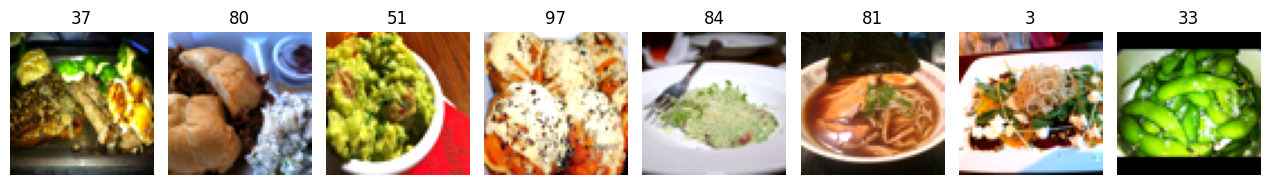

In [3]:
import matplotlib.pyplot as plt

def show_batch(images, labels, n=8):
    mean = torch.tensor((0.5071, 0.4867, 0.4408)).view(1,3,1,1)
    std  = torch.tensor((0.2675, 0.2565, 0.2761)).view(1,3,1,1)

    imgs = images[:n].cpu() * std + mean
    imgs = imgs.clamp(0, 1)

    fig, axes = plt.subplots(1, n, figsize=(1.6*n, 2))
    for i in range(n):
        axes[i].imshow(imgs[i].permute(1,2,0))
        axes[i].set_title(str(labels[i].item()))
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()


images, labels = next(iter(train_loader))
show_batch(images, labels, n=8)

In [ ]:
def outgrid_64x64(drop_path=0.07):
    return [
        StageCfg(dim=48,  depth=1, num_heads=2, grid_size=8, outlook_heads=2, drop_path=drop_path),
        StageCfg(dim=96,  depth=2, num_heads=3, grid_size=8, outlook_heads=3, drop_path=drop_path),
        StageCfg(dim=192, depth=2, num_heads=6, grid_size=4, outlook_heads=6, drop_path=drop_path),
        StageCfg(dim=256, depth=1, num_heads=8, grid_size=2, outlook_heads=8, drop_path=drop_path)]

stages = outgrid_64x64()


model = MaxOutNet(
    num_classes=101,
    stages=stages,
    stem_dim=64,
    dpr_max=0.1)

device = "cuda" if torch.cuda.is_available() else "cpu"

In [39]:
import random, numpy as np
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import warnings
warnings.filterwarnings(
    "ignore",
    category=UserWarning,
    module="PIL.TiffImagePlugin")


seed = 77
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

random.seed(seed);
np.random.seed(seed)
torch.backends.cudnn.benchmark = True


history1, model = train_model(
    model=model,
    train_loader=train_loader,
    epochs=25,
    val_loader=val_loader,
    device=device,

    lr=5e-4,
    weight_decay=0.05,

    autocast_dtype="fp16" if device == "cuda" else "fp32",
    use_amp=(device == "cuda"),
    grad_clip_norm=1.0,

    warmup_ratio=0.05,
    min_lr=1e-6,

    label_smoothing=0.1,

    print_every=400,
    save_path="best_OutGrid.pt",
    last_path="last_OutGrid.pt",
    resume_path=None,

    # Augmentationsas
    mix_prob=0.5,
    mixup_alpha=0.4,
    cutmix_alpha=0.4,

    num_classes=101,
    channels_last=True)

#T4

=== Run config ===
device=cuda | amp=True | autocast_dtype=fp16 | channels_last=True
epochs=25 | steps/epoch=1183 | total_steps=29575 | warmup_steps=1478
batch_size=64 | input_shape=(64, 3, 64, 64) | num_classes=101
opt=AdamW | lr=0.0005 | wd=0.05 | grad_clip_norm=1.0
aug: mix_prob=0.5 | mixup_alpha=0.4 | cutmix_alpha=0.4 | label_smoothing=0.1

=== Epoch 1/25 ===
[train step 400/1183] loss 4.4235 | top1 4.33% | top3 10.34% | top5 15.23% | 132.4 img/s | lr 1.35e-04 | gnorm 3.485 | clip 100.0% | oflow 0 | nonfinite 0 | scale 65536.0
[train step 800/1183] loss 4.2647 | top1 6.50% | top3 14.79% | top5 20.92% | 139.4 img/s | lr 2.71e-04 | gnorm 3.535 | clip 100.0% | oflow 0 | nonfinite 0 | scale 65536.0
[train step 1183/1183] loss 4.1397 | top1 8.44% | top3 18.37% | top5 25.23% | 141.8 img/s | lr 4.00e-04 | gnorm 3.488 | clip 100.0% | oflow 0 | nonfinite 0 | scale 65536.0
[Train] loss 4.1397 | top1 8.44% | top3 18.37% | top5 25.23% | lr 4.00e-04 | grad_norm 3.488 | clip 100.0% | amp_overflo

In [40]:
import pickle

with open("OutGrid_OxfordPets.pkl", "wb") as f:
    pickle.dump(history1, f)

---

## OxfordPets 37

In [ ]:
from src.data.load_oxfordpets import *

train_loader, val_loader, test_loader = get_oxford_pets37_dataloaders(
     batch_size=64, img_size=64, val_split=0.1, num_workers=4, seed=7)

In [ ]:
def outgrid_64x64(drop_path=0.07):
    return [
        StageCfg(dim=48,  depth=1, num_heads=2, grid_size=8, outlook_heads=2, drop_path=drop_path),
        StageCfg(dim=96,  depth=2, num_heads=3, grid_size=8, outlook_heads=3, drop_path=drop_path),
        StageCfg(dim=192, depth=2, num_heads=6, grid_size=4, outlook_heads=6, drop_path=drop_path),
        StageCfg(dim=256, depth=1, num_heads=8, grid_size=2, outlook_heads=8, drop_path=drop_path)]

stages = outgrid_64x64()


model = MaxOutNet(
    num_classes=37,
    stages=stages,
    stem_dim=64,
    dpr_max=0.1)

device = "cuda" if torch.cuda.is_available() else "cpu"

In [31]:
avg_loss, metrics = evaluate_one_epoch_logs(
    model=model,
    dataloader=test_loader,
    device="cuda",
    use_amp=True,
    autocast_dtype="fp16",
    channels_last=False,
    measure_flops=True,
    flops_warmup_batches=1)

print(f"loss: {avg_loss:.4f}")
print(f"top1: {metrics['top1']:.2f} | top3: {metrics['top3']:.2f} | top5: {metrics['top5']:.2f}")

print(f"throughput: {metrics['imgs_per_sec']:.1f} imgs/s | epoch: {metrics['epoch_time_sec']:.2f}s | ms/batch: {metrics['ms_per_batch']:.2f}")
print(f"GPU mem: alloc={metrics['gpu_mem_allocated_mib']:.0f} MiB | reserved={metrics['gpu_mem_reserved_mib']:.0f} MiB | peak={metrics['gpu_mem_peak_allocated_mib']:.0f} MiB")
print(f"model: params={int(metrics['model_params']):,} | param_size={metrics['model_param_size_mib']:.1f} MiB")

flops = metrics["flops_per_forward"]
macs  = metrics["macs_per_forward"]

print(
    f"Compute (per forward): "
    f"{format_ops(flops, 'FLOPs')} | "
    f"{format_ops(macs, 'MACs')}")

Unsupported operator aten::silu_ encountered 22 time(s)
Unsupported operator aten::softmax encountered 12 time(s)
Unsupported operator aten::im2col encountered 6 time(s)
Unsupported operator aten::mul encountered 42 time(s)
Unsupported operator aten::sum encountered 6 time(s)
Unsupported operator aten::add encountered 30 time(s)
Unsupported operator aten::gelu encountered 12 time(s)
Unsupported operator aten::sigmoid encountered 6 time(s)
Unsupported operator aten::mean encountered 1 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by direct calls to .forward() or via other python methods. In the latter case they will have zeros for statistics, though their statistics will still contribute to their parent calling module.
stages.1.0.dp2, stages.1.0.dp3, stages.1.0.outlook.dp1, stages.1.0.outlook.dp2, stages.1.1.dp2, stages.1.1.dp3, stages.1.1.outlook.dp1, stages.1.1.outlook.dp2, stages.2.0.dp2, stage

loss: 3.6507
top1: 3.30 | top3: 9.08 | top5: 14.66
throughput: 243.0 imgs/s | epoch: 15.10s | ms/batch: 180.85
GPU mem: alloc=33 MiB | reserved=1148 MiB | peak=845 MiB
model: params=6,222,561 | param_size=23.7 MiB
Compute (per forward): 1.56 GFLOPs | 780.52 MMACs


In [33]:
seed = 77
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

random.seed(seed);
np.random.seed(seed)
torch.backends.cudnn.benchmark = True


history1, model_vit3 = train_model(
    model=model,
    train_loader=train_loader,
    epochs=25,
    val_loader=val_loader,
    device=device,

    lr=5e-4,
    weight_decay=0.05,

    autocast_dtype="fp16" if device == "cuda" else "fp32",
    use_amp=(device == "cuda"),
    grad_clip_norm=1.0,

    warmup_ratio=0.05,
    min_lr=1e-6,

    label_smoothing=0.1,

    print_every=400,
    save_path="best_Swin.pt",
    last_path="last_Swin.pt",
    resume_path=None,

    # Augmentations
    mix_prob=0.5,
    mixup_alpha=0.4,
    cutmix_alpha=0.4,

    num_classes=37, early_stop_patience=25,
    channels_last=True)

#T4 

=== Run config ===
device=cuda | amp=True | autocast_dtype=fp16 | channels_last=True
epochs=25 | steps/epoch=51 | total_steps=1275 | warmup_steps=63
batch_size=64 | input_shape=(64, 3, 64, 64) | num_classes=37
opt=AdamW | lr=0.0005 | wd=0.05 | grad_clip_norm=1.0
aug: mix_prob=0.5 | mixup_alpha=0.4 | cutmix_alpha=0.4 | label_smoothing=0.1

=== Epoch 1/25 ===
[train step 51/51] loss 3.5308 | top1 5.97% | top3 16.39% | top5 23.84% | 79.9 img/s | lr 4.05e-04 | gnorm 3.717 | clip 100.0% | oflow 0 | nonfinite 0 | scale 65536.0
[Train] loss 3.5308 | top1 5.97% | top3 16.39% | top5 23.84% | lr 4.05e-04 | grad_norm 3.717 | clip 100.0% | amp_overflows 0 | nonfinite_loss 0 | scale 65536.0
[Train] mem_peak alloc 4.78 GiB | reserved 5.62 GiB
[Val]   loss 3.6360 | top1 7.07% | top3 19.02% | top5 26.63%
[Val]   mem_peak alloc 0.90 GiB | reserved 5.62 GiB
Best saved to best_Swin.pt (val top1 7.07%)
Epoch time: 0.76 min

=== Epoch 2/25 ===
[train step 51/51] loss 3.3595 | top1 9.19% | top3 23.31% | top

In [34]:
evaluate_one_epoch(model=model,dataloader=test_loader)

(2.685618084176875,
 {'top1': 29.32679204142818,
  'top3': 51.62169528481875,
  'top5': 62.578359225947125})

In [36]:
import pickle

with open("OutGrid_OxfordPets.pkl", "wb") as f:
    pickle.dump(history1, f)

---

## SVHN 

In [ ]:
from src.data.load_svhn import *

train_loader, val_loader, test_loader = get_svhn_dataloaders(
     batch_size=64, img_size=32, val_split=0.1, num_workers=4)

In [ ]:
def outgrid_32x32(drop_path=0.07):
    return [
        StageCfg(dim=48,  depth=1, num_heads=2, grid_size=8, outlook_heads=2, drop_path=drop_path),
        StageCfg(dim=96,  depth=2, num_heads=3, grid_size=8, outlook_heads=3, drop_path=drop_path),
        StageCfg(dim=192, depth=3, num_heads=6, grid_size=4, outlook_heads=6, drop_path=drop_path),
        StageCfg(dim=256, depth=1, num_heads=8, grid_size=2, outlook_heads=8, drop_path=drop_path),]


stages = outgrid_32x32(drop_path=0.07)

model = MaxOutNet(
    num_classes=10,
    stages=stages,
    stem_dim=64,
    dpr_max=0.09)

device = "cuda"

In [42]:
avg_loss, metrics = evaluate_one_epoch_logs(
    model=model,
    dataloader=test_loader,
    device="cuda",
    use_amp=True,
    autocast_dtype="fp16",
    channels_last=False,
    measure_flops=True,
    flops_warmup_batches=1)

print(f"loss: {avg_loss:.4f}")
print(f"top1: {metrics['top1']:.2f} | top3: {metrics['top3']:.2f} | top5: {metrics['top5']:.2f}")

print(f"throughput: {metrics['imgs_per_sec']:.1f} imgs/s | epoch: {metrics['epoch_time_sec']:.2f}s | ms/batch: {metrics['ms_per_batch']:.2f}")
print(f"GPU mem: alloc={metrics['gpu_mem_allocated_mib']:.0f} MiB | reserved={metrics['gpu_mem_reserved_mib']:.0f} MiB | peak={metrics['gpu_mem_peak_allocated_mib']:.0f} MiB")
print(f"model: params={int(metrics['model_params']):,} | param_size={metrics['model_param_size_mib']:.1f} MiB")

flops = metrics["flops_per_forward"]
macs  = metrics["macs_per_forward"]

print(
    f"Compute (per forward): "
    f"{format_ops(flops, 'FLOPs')} | "
    f"{format_ops(macs, 'MACs')}")

Unsupported operator aten::silu_ encountered 25 time(s)
Unsupported operator aten::softmax encountered 14 time(s)
Unsupported operator aten::im2col encountered 7 time(s)
Unsupported operator aten::mul encountered 49 time(s)
Unsupported operator aten::sum encountered 7 time(s)
Unsupported operator aten::add encountered 35 time(s)
Unsupported operator aten::gelu encountered 14 time(s)
Unsupported operator aten::sigmoid encountered 7 time(s)
Unsupported operator aten::mean encountered 1 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by direct calls to .forward() or via other python methods. In the latter case they will have zeros for statistics, though their statistics will still contribute to their parent calling module.
stages.1.0.dp2, stages.1.0.dp3, stages.1.0.outlook.dp1, stages.1.0.outlook.dp2, stages.1.1.dp2, stages.1.1.dp3, stages.1.1.outlook.dp1, stages.1.1.outlook.dp2, stages.2.0.dp2, stage

loss: 2.3899
top1: 9.70 | top3: 26.36 | top5: 44.05
throughput: 1101.0 imgs/s | epoch: 23.64s | ms/batch: 51.27
GPU mem: alloc=141 MiB | reserved=246 MiB | peak=393 MiB
model: params=7,494,972 | param_size=28.6 MiB
Compute (per forward): 447.99 MFLOPs | 224.00 MMACs


In [43]:
seed = 77
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

random.seed(seed);
np.random.seed(seed)
torch.backends.cudnn.benchmark = True


history1, model = train_model(
    model=model,
    train_loader=train_loader,
    epochs=10,
    val_loader=val_loader,
    device=device,

    lr=5e-4,
    weight_decay=0.05,

    autocast_dtype="fp16" if device == "cuda" else "fp32",
    use_amp=(device == "cuda"),
    grad_clip_norm=1.0,

    warmup_ratio=0.05,
    min_lr=1e-6,

    label_smoothing=0.1,

    print_every=400,
    save_path="best_outgrid32.pt",
    last_path="last_outgrid32.pt",
    resume_path=None,

    # Augmentations
    mix_prob=0.5,
    mixup_alpha=0.4,
    cutmix_alpha=0.4,

    num_classes=10,
    channels_last=True)

=== Run config ===
device=cuda | amp=True | autocast_dtype=fp16 | channels_last=True
epochs=10 | steps/epoch=1031 | total_steps=10310 | warmup_steps=515
batch_size=64 | input_shape=(64, 3, 32, 32) | num_classes=10
opt=AdamW | lr=0.0005 | wd=0.05 | grad_clip_norm=1.0
aug: mix_prob=0.5 | mixup_alpha=0.4 | cutmix_alpha=0.4 | label_smoothing=0.1

=== Epoch 1/10 ===
[train step 400/1031] loss 1.6538 | top1 45.87% | top3 66.82% | top5 79.17% | 407.0 img/s | lr 3.88e-04 | gnorm 5.272 | clip 100.0% | oflow 0 | nonfinite 0 | scale 65536.0
[train step 800/1031] loss 1.2839 | top1 62.23% | top3 79.27% | top5 87.56% | 448.0 img/s | lr 4.99e-04 | gnorm 3.725 | clip 100.0% | oflow 0 | nonfinite 0 | scale 65536.0
[train step 1031/1031] loss 1.1826 | top1 66.28% | top3 82.15% | top5 89.43% | 412.9 img/s | lr 4.97e-04 | gnorm 3.259 | clip 99.3% | oflow 0 | nonfinite 0 | scale 65536.0
[Train] loss 1.1826 | top1 66.28% | top3 82.15% | top5 89.43% | lr 4.97e-04 | grad_norm 3.259 | clip 99.3% | amp_overflo

In [44]:
evaluate_one_epoch(model=model,dataloader=test_loader)

(0.16355300522063068,
 {'top1': 96.7578365089121,
  'top3': 99.18945912722803,
  'top5': 99.6081745543946})

In [45]:
import pickle

with open("OutGrid_SVHN.pkl", "wb") as f:
    pickle.dump(history1, f)